# 시스템리스크

In [ ]:
import requests
import pandas as pd
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

## 날짜 데이터 만들기

In [2]:
# 분기별 날짜 데이터
dates = pd.date_range('20000301', periods=88, freq='BQ-MAR')
dates = [date.strftime("%Y%m%d") for date in dates]

In [3]:
# 연도별 날짜 데이터
dates = pd.date_range('20000101', periods=22, freq='BA')
dates = [date.strftime("%Y%m%d") for date in dates]

## KRX로 데이터 불러오기

In [3]:
def get_krx_data(date):
    gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'

    gen_otp_data = {
        'mktId': 'ALL',
        'trdDd': str(date),
        'share': '1',
        'money': '1',
        'csvxls_isNo': 'false',
        'name': 'fileDown',
        'url': 'dbms/MDC/STAT/standard/MDCSTAT01501'
    }

    headers = {'Referer': 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC0201020101'}
    otp = requests.post(gen_otp_url, gen_otp_data, headers=headers).text

    down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
    down_sector_KS = requests.post(down_url, {'code': otp}, headers=headers)
    df = pd.read_csv(BytesIO(down_sector_KS.content), encoding='EUC-KR')
    return df

In [140]:
date = dates[3]
t = get_krx_data(date)

In [222]:
from tqdm.notebook import tqdm
from datetime import datetime, timedelta

df = pd.DataFrame()
for date in tqdm(dates):
    
    t = get_krx_data(date)
    
    if t.sum()['시가총액'] == 0:
        dd = datetime.strptime(date, "%Y%m%d") + timedelta(days=-1)
        dd = dd.strftime("%Y%m%d")
        t = get_krx_data(dd)
        
        while t.sum()['시가총액'] == 0:
            t = get_krx_data(dd)
            dd = datetime.strptime(dd, "%Y%m%d") + timedelta(days=-1)
            dd = dd.strftime("%Y%m%d")

    거래대금 = t.sum()['거래대금']
    시가총액 = t.sum()['시가총액']
    df[date] = [거래대금, 시가총액]
    
df = df.T
df.columns = ['거래대금', '시가총액']

  0%|          | 0/22 [00:00<?, ?it/s]

In [223]:
# 데이터 저장
df.to_csv("./data/주식(연).csv")

In [224]:
# 저장된 데이터 불러오기
df = pd.read_csv("./data/주식(연).csv", index_col=0)
df.head(3)

,거래대금,시가총액
20001229,2045028342610,261373478132610
20011231,3907113771080,307940266653795
20021231,4081287322415,296356030559855


## 국내 금융구조

### 규모지수

In [160]:
bank_total = pd.read_csv("./data/은행 총자산.csv", index_col=0, thousands=',')
bank_total = bank_total*1000000

In [232]:
bank_total = pd.read_csv("./data/은행 총자산(연).csv", index_col=0, thousands=',')
bank_total = bank_total*1000000

In [234]:
규모지수 = pd.DataFrame()
규모지수['상장주식 시가총액'] = df['시가총액']
규모지수['은행 총자산'] = bank_total.sum().values
규모지수['규모지수'] = 규모지수['상장주식 시가총액'] / 규모지수['은행 총자산']
규모지수['규모지수'] = (규모지수['규모지수'] / 규모지수['규모지수'].values[0])*100

In [168]:
Qdate = pd.period_range('2000Q1', '2021Q4', freq='Q-FEB')
Qdate = [str(date)[2:] for date in Qdate]

In [182]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = 'C:\\Users\\min\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NEXON Lv2 Gothic Medium.ttf'
fontprop = fm.FontProperties(fname=path).get_name()
plt.rc('font', family = fontprop)

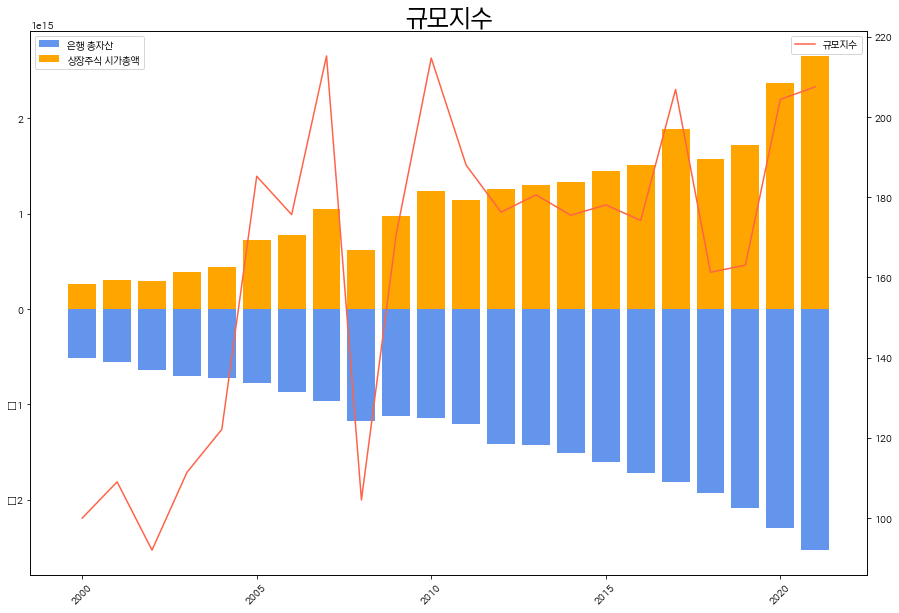

In [247]:
import numpy as np

x = np.arange(2000, 2022)
y0 = 규모지수['상장주식 시가총액']
y1 = 규모지수['은행 총자산']
y2 = 규모지수['규모지수']

fig, ax1 = plt.subplots(figsize=(15, 10))

ax1.bar(x, -y1, label = '은행 총자산', color = 'cornflowerblue')
ax1.bar(x, y0, label = '상장주식 시가총액', color = 'orange')
plt.legend()
plt.xticks(rotation=45, fontsize=10)

ax2 = ax1.twinx()
ax2.plot(x, y2, label='규모지수', color = 'tomato')

plt.legend()
plt.title("규모지수", fontsize=25)
plt.show()

### 활동성 지수

In [266]:
# 데이터 불러오기
credit = pd.read_csv("./data/은행 민간신용(연).csv", thousands=',', index_col=0)
credit = credit*1000000

In [271]:
활동성지수 = df['거래대금'].values / credit.sum().values
활동성지수 = (활동성지수 / 활동성지수[0])*100

### 효율성 지수

In [295]:
cost = pd.read_csv("./data/은행 영업비용(연).csv", thousands=',', index_col=0)
cost = cost*1000000

In [303]:
간접비용 = cost.loc['영업비용:당분기'].sum() - cost.loc['이자비용:당분기'].sum()

In [306]:
# 주식 거래대금/시가총액 비율
효율성지수 = (df['거래대금'].values / df['시가총액'].values) * (간접비용.values / bank_total.sum().values)
효율성지수 = (효율성지수 / 효율성지수[0])*100

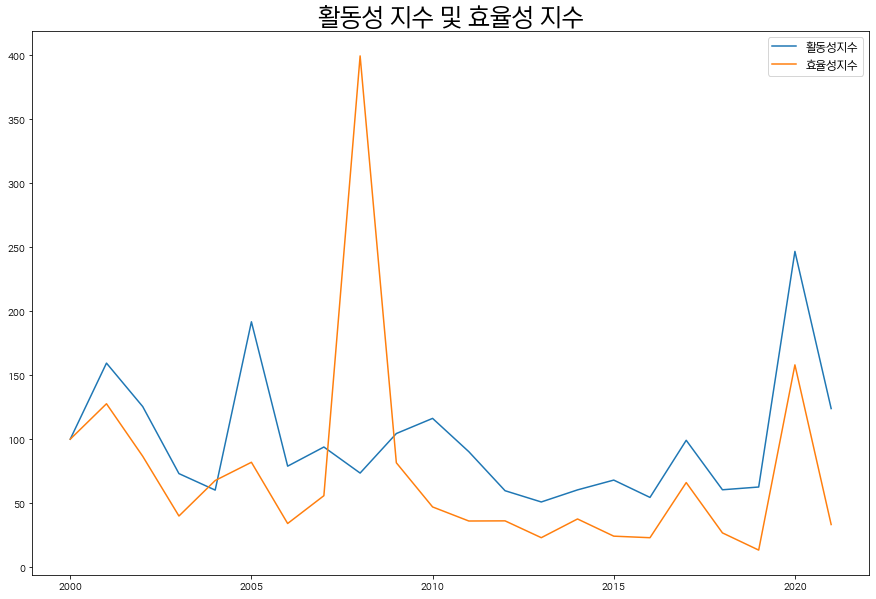

In [312]:
plt.figure(figsize=(15, 10))
plt.plot(x, 활동성지수, label = '활동성지수')
plt.plot(x, 효율성지수, label = '효율성지수')
plt.legend(fontsize=12)
plt.title("활동성 지수 및 효율성 지수", fontsize=25)
plt.show()

## 은행 시장 구조

### CR 지수

In [9]:
총자산 = pd.read_csv("./data/은행 총자산(연).csv",thousands=',', index_col=0)

In [29]:
점유율 = pd.DataFrame(index=총자산.index, columns=총자산.columns)
for col in 총자산.columns:
    점유율[col] = (총자산.loc[:, col] / 총자산.loc[:, col].sum())*100

In [4]:
CR4 = []
CR3 = []
for col in 점유율:
    CR4.append(점유율[col].sort_values(ascending=False)[:4].sum())
    CR3.append(점유율[col].sort_values(ascending=False)[:3].sum())

In [5]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = 'C:\\Users\\min\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NEXON Lv2 Gothic Medium.ttf'
fontprop = fm.FontProperties(fname=path).get_name()
plt.rc('font', family = fontprop)

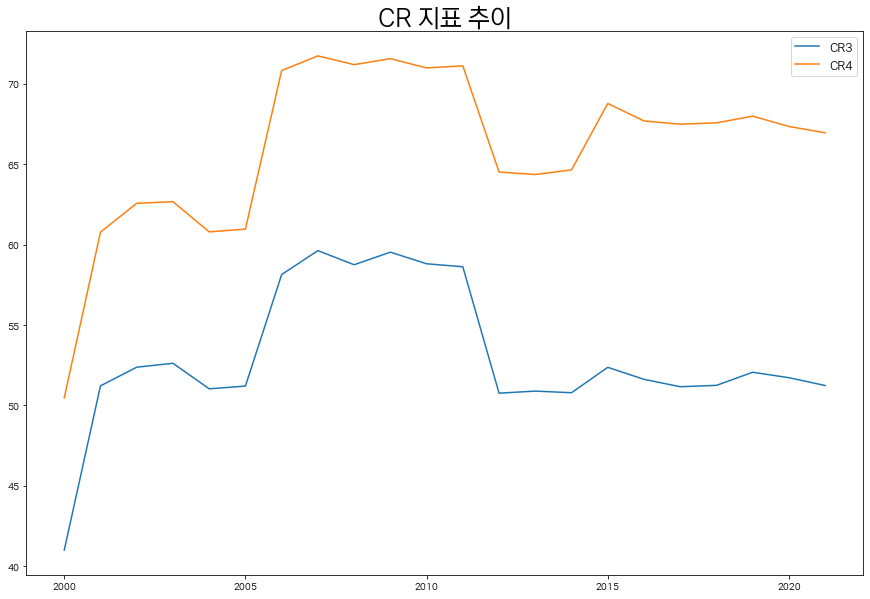

In [6]:
import numpy as np

x = np.arange(2000, 2022)
plt.figure(figsize=(15, 10))
plt.plot(x, CR3, label = 'CR3')
plt.plot(x, CR4, label = 'CR4')
plt.legend(fontsize=12)
plt.title("CR 지표 추이", fontsize=25)
plt.show()

### HHI

In [30]:
HHI = (점유율**2).sum()

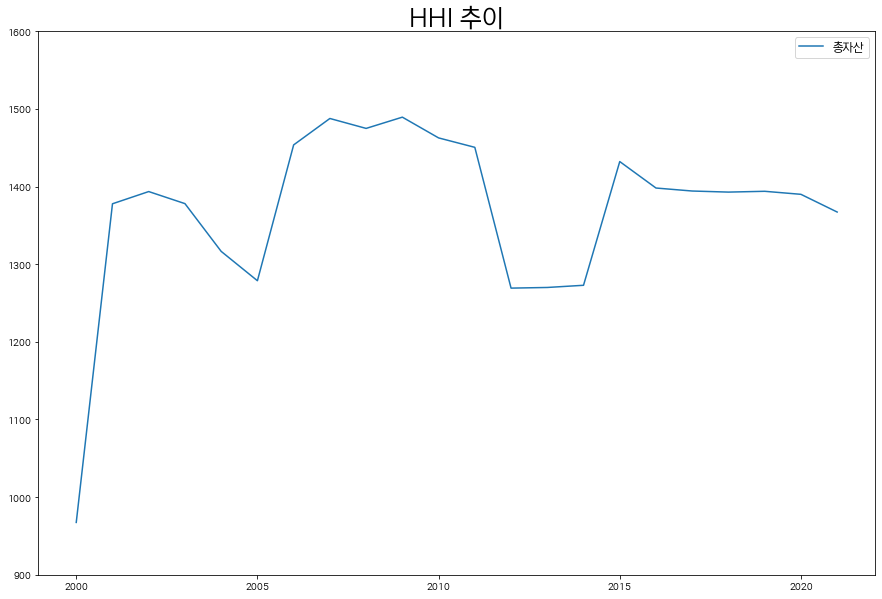

In [31]:
import numpy as np

x = np.arange(2000, 2022)
plt.figure(figsize=(15, 10))
plt.plot(x, HHI, label = '총자산')
# plt.plot(x, CR4, label = 'CR4')
plt.legend(fontsize=12)
plt.title("HHI 추이", fontsize=25)
plt.ylim([900, 1600])
plt.show()

## 동조화지수

In [2]:
# 데이터 불러오기
대출 = pd.read_csv('./data/5대 은행 대출.csv', thousands=',')
유가증권 = pd.read_csv('./data/5대 은행 유가증권.csv', thousands=',')
총자산 = pd.read_csv('./data/5대 은행 자산 총계.csv', thousands=',')

In [115]:
기업대출 = 대출[대출.구분 == '기업자금']
가계대출 = 대출[대출.구분 == '가계자금']

기업대출.drop('구분', axis=1, inplace=True)
가계대출.drop('구분', axis=1, inplace=True)

In [116]:
유가증권 = 유가증권.loc[:, 유가증권.iloc[0] != '구성비']
유가증권 = 유가증권.iloc[1:]

In [117]:
총자산 = 총자산.loc[:, 총자산.iloc[0] != '구성비']
총자산 = 총자산.iloc[1:]

In [124]:
기업대출.columns = 총자산.columns
가계대출.columns = 총자산.columns
유가증권.columns = 총자산.columns

In [148]:
기업대출.index = 기업대출.iloc[:, 0]
가계대출.index = 기업대출.iloc[:, 0]
유가증권.index = 기업대출.iloc[:, 0]
총자산.index = 기업대출.iloc[:, 0]

기업대출 = 기업대출.iloc[:, 1:]
가계대출 = 가계대출.iloc[:, 1:]
유가증권 = 유가증권.iloc[:, 1:]
총자산 = 총자산.iloc[:, 1:]

In [154]:
for col in 유가증권.columns:
    기업대출[col] = 기업대출[col].astype('float')
    가계대출[col] = 가계대출[col].astype('float')
    유가증권[col] = 유가증권[col].astype('float')
    총자산[col] = 총자산[col].astype('float')

In [203]:
기업대출_rt = pd.DataFrame()
가계대출_rt = pd.DataFrame()
유가증권_rt = pd.DataFrame()

for col in 기업대출.columns:
    기업대출_rt[col] = (기업대출[col] / 총자산[col])
    가계대출_rt[col] = (가계대출[col] / 총자산[col])
    유가증권_rt[col] = (유가증권[col] / 총자산[col])

## 회귀분석

In [6]:
cgap = pd.read_csv("./data/CGAP.csv")
reer = pd.read_csv("./data/REER.csv")
rppr = pd.read_csv('./data/RPPR.csv')
stkp = pd.read_csv('./data/STKP.csv')
fsi = pd.read_csv('./data/FSI.csv', encoding='cp949')
hmgi = pd.read_csv('./data/동조화지수.csv')

### 전처리

- cgap: 분기데이터, 2008년 1분기 ~ 2022년 1분기
- reer: 월데이터, 1994년 1월 ~ 2022년 6월
- rppr: 월데이터, 2006년 1월 ~ 2022년 5월
- stkp: 월데이터, 2000년 1월 ~ 2022년 8월
- fsi: 월데이터, 2007년 1월 ~ 2022년 5월
- hmgi: 분기데이터, 2000년 4분기 ~ 2022년 1분기
- 분기데이터로, 2008년 1분기 ~ 2022년 1분기로 데이터 전처리하기

In [ ]:
import pandas as pd
import statsmodels.api as sm

In [163]:
reer = reer[pd.to_datetime(reer['날짜']) >= '2008-01-01']
reer = reer[(reer['날짜'].str[:2] == "03") | (reer['날짜'].str[:2] == "06") | (reer['날짜'].str[:2] == "09") | (reer['날짜'].str[:2] == "12")]

In [164]:
rppr['날짜'] = rppr['날짜'].str[6:8] + "-" + rppr['날짜'].str[:4]
rppr = rppr[pd.to_datetime(rppr['날짜']) >= '2008-01-01']
rppr = rppr[(rppr['날짜'].str[:2] == "03") | (rppr['날짜'].str[:2] == "06") | (rppr['날짜'].str[:2] == "09") | (rppr['날짜'].str[:2] == "12")]

In [165]:
stkp = stkp[pd.to_datetime(stkp['날짜']) >= '2008-01-01']
stkp = stkp[(stkp['날짜'].str[:2] == "03") | (stkp['날짜'].str[:2] == "06") | (stkp['날짜'].str[:2] == "09") | (stkp['날짜'].str[:2] == "12")]

In [7]:
fsi = fsi[pd.to_datetime(fsi['날짜']) >= '2008-01-01']
fsi = fsi[(fsi['날짜'].str[:2] == "03") | (fsi['날짜'].str[:2] == "06") | (fsi['날짜'].str[:2] == "09") | (fsi['날짜'].str[:2] == "12")]

In [168]:
hmgi = hmgi[pd.to_datetime(hmgi['날짜']) >= '2008-01-01']
hmgi = hmgi[(hmgi['날짜'].str[5:8] == "03") | (hmgi['날짜'].str[5:8] == "06") | (hmgi['날짜'].str[5:8] == "09") | (hmgi['날짜'].str[5:8] == "12")]

In [178]:
len(cgap), len(reer), len(rppr), len(stkp), len(fsi), len(hmgi)

(57, 58, 57, 58, 57, 57)

In [183]:
reer = reer[:-1]
stkp = stkp[:-1]

In [ ]:
cgap.reset_index(drop=True, inplace=True)
reer.reset_index(drop=True, inplace=True)
rppr.reset_index(drop=True, inplace=True)
stkp.reset_index(drop=True, inplace=True)
fsi.reset_index(drop=True, inplace=True)
hmgi.reset_index(drop=True, inplace=True)

In [214]:
fsi1 = fsi.iloc[1:]
fsi1.reset_index(drop=True, inplace=True)

In [216]:
df = pd.concat([cgap[['날짜', '민간']], reer['실질실효환율'], rppr['실질주택가격지수'], stkp['종가'], fsi1['금융안정지수'], hmgi['HMGI']], axis=1)
df.to_csv('./data/dataset.csv')

In [32]:
df = pd.read_csv('./data/dataset.csv', index_col=0, thousands=',')
df = pd.concat([df,fsi['금융안정지수']], axis=1)
df.columns = ['날짜', 'CGAP', 'REER', 'RPPR', 'STKP', 'FSI_1', 'HMGI', 'FSI']
df = df.iloc[:-1]

In [52]:
X = df.iloc[:, 1:7]
y = df.FSI.values

In [46]:
X1 = df[['CGAP', 'REER', 'RPPR', 'STKP', 'FSI_1']]

In [53]:
results = sm.OLS(y, sm.add_constant(X)).fit()
results1 = sm.OLS(y, sm.add_constant(X1)).fit()

In [54]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     31.67
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           3.00e-15
Time:                        13:45:31   Log-Likelihood:                -163.55
No. Observations:                  56   AIC:                             341.1
Df Residuals:                      49   BIC:                             355.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.6997     16.877      4.130      0.000      35.784     103.615
CGAP          -0.1217      0.176     -0.692      0.492      -0.475       0.232
REER          -0.6569      0.179     -3.668      0.001      -1.017      -0.297
RPPR           0.3119      0.110      2.831      0.007       0.091       0.533
STKP          -0.0122      0.004     -2.945      0.005      -0.021      -0.004
FSI_1          0.4428      0.087      5.093      0.000       0.268       0.617
HMGI           1.6231      7.969      0.204      0.839     -14.391      17.637
==============================================================================
Omnibus:                       14.163   Durbin-Watson:                   1.177
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.629
Skew:                           0.857   Prob(JB):                     3.31e-05
Kurtosis:                       5.430   Cond. No.                     5.56e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [51]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     38.73
Date:                Fri, 12 Aug 2022   Prob (F-statistic):           4.64e-16
Time:                        13:44:56   Log-Likelihood:                -163.57
No. Observations:                  56   AIC:                             339.1
Df Residuals:                      50   BIC:                             351.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         70.2628     16.489      4.261      0.000      37.144     103.381
CGAP          -0.1146      0.171     -0.671      0.505      -0.458       0.229
REER          -0.6570      0.177     -3.704      0.001      -1.013      -0.301
RPPR           0.3092      0.108      2.855      0.006       0.092       0.527
STKP          -0.0120      0.004     -3.025      0.004      -0.020      -0.004
FSI_1          0.4404      0.085      5.162      0.000       0.269       0.612
==============================================================================
Omnibus:                       13.360   Durbin-Watson:                   1.174
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.013
Skew:                           0.815   Prob(JB):                     7.44e-05
Kurtosis:                       5.343   Cond. No.                     5.47e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""